# STOR 566, Homework 5
### Instructor: Yao Li
### Keywords: Adversarial Robustness
### Due date: Oct 30, 11:55pm
### **Submission Instruction**

- Please download this script and use it to answer the questions in the homework. 
- For submission, please include your code, code output and answers in the script and submit the ipynb file on sakai.
- Please don't modify existing cells. But you can add cells between the exercise statements.
- To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language. For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

### **References:**

- You can follow the setup instructions at [here](https://pytorch.org/get-started/locally/).
- A useful tutorial on learning pytorch by examples at [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).
- Check Pytorch optimization methods at [here](https://pytorch.org/docs/stable/optim.html).
- Check implementation of different attack methods at [here](https://github.com/Harry24k/adversarial-attacks-pytorch) for reference. 


### **Method Review**

- PGD: L-infinity norm restricted attack
	\begin{align}
	x^{t+1}=\Pi_{\epsilon}\{x^t+\alpha\cdot\text{sign}(\nabla_xL(\theta,x,y)),x_0\}
	\end{align}	
    - $x^{t+1}$: the adversarial example generated from step t+1
    - $\epsilon$: epsilon, which controls the perturbation
    - $\Pi_\epsilon$: project the input to the epsilon-ball around $x_0$
    - $\alpha$: step size
    - $\text{sign}(\nabla_xL(\theta,x,y))$: sign of gradient
    - Don't forget to project $x^{t+1}$ to the valid pixel value range. If you don't modify the data loader, the valid pixel value range is $[0,1]$.

- C&W: L-2 norm targeted attack
	\begin{align}
	x^{*}=\arg\min_{x}\|x-x_0\|^2+\lambda\cdot\max\{\max_{j\ne t}f_j(x)-f_t(x),\kappa\}
	\end{align}	
    - $x^{*}$: the adversarial example
    - $\lambda$: parameter that controls the balance between distortion and the attack success. 
    - $f_j(x)$: the logits (predicted score) of class j
    - $t$: the target class
    - $\kappa$: confidence
    - Don't forget to project the $x^{*}$ to $[0,1]$.

- Adversarial training
	\begin{align}
	\arg\min_\theta E_{(x,y)\sim D}\{\max_{\|\delta\|\le\epsilon}L(\theta,x+\delta,y)\}
	\end{align}	
    - $\theta$: model parameters
    - $D$: clean data distribution
    - $\delta$: adversarial perturbation
    - For each batch, generate adversarial examples based on the batch of samples, then update the model with adversarial examples 
    
### **Evaluation Metrics:**

- Testing accuracy: 
	\begin{align}
	\frac{1}{N}\sum_{i=1}^N {\bf 1}(\hat{y}_i=y_i)
	\end{align}	
    - $N$: the total number of samples in the testing set
    - $y_i$: true label of sample $x_i$
    - $\hat{y}_i$: predicted label by the model

- Robust Testing Accuracy: testing accuracy on adversarial examples

	\begin{align}
	\frac{1}{N}\sum_{i=1}^N {\bf 1}(c(x^*_i)=y_i)
	\end{align}	
    - $N$: the total number of samples in the testing set
    - $x^*_i$: adversarial example generated from $x_i$
    - $c(\cdot)$: returns the label predicted by the model
    - $c(x^*_i)$: predicted label of adversarial example by the model
    - $y_i$: true label of sample $x_i$

## Problem 1 (50 points)

In this problem you will practice implementing **PGD attack** and **targetted C&W attack** on CIFAR10 data set.

**Data.** You will use CIFAR10 classification dataset (10 classes). Pytorch/torchvision has provide a useful dataloader to automatically download and load the data into batches. Code of the data loader has been provided in the template. Please don't modify the data loading part.

In [1]:
## The following code can change the working directory to your google drive
## So you don't need to download the data every time

import os
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')


Mounted at /content/drive


In [2]:
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torch.utils.data as td
import random, time
import matplotlib.pyplot as plt
import torchvision
import PIL.Image as Image
from tqdm import tqdm
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [46]:
## Data loading code chunk, please don't modify it. 
## However, you can adjust the batch size if you want to.
batch_size_cifar = 128

def cifar_loaders(batch_size, shuffle_test=False): 
    data_dir = './data'
    train = datasets.CIFAR10(data_dir, train=True, download=True, 
        transform=transforms.Compose([
            transforms.ToTensor(),
        ]))
    # Once you have downloaded the data by setting download=True, you can
    # change download=True to download=False
    test = datasets.CIFAR10(data_dir, train=False, 
        transform=transforms.Compose([transforms.ToTensor()]))
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
        shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
        shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader

train_cifar_loader, test_cifar_loader = cifar_loaders(batch_size_cifar)

# Get the loader that only loads class 0 image (for question 1.d)
def subset_loaders(batch_size=128): 
    data_dir = './data'
    test = datasets.CIFAR10(data_dir, train=False, 
        transform=transforms.Compose([transforms.ToTensor()]))
    subset_indices = (torch.tensor(test.targets) == 0).nonzero()
    test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size, 
          shuffle=False,sampler=SubsetRandomSampler(subset_indices))
    return test_loader

sub_loader = subset_loaders()

Files already downloaded and verified


In [47]:
## Load the pre-trained VGG11bn model
## For this step, you need to put the vgg.py and vgg11_bn.pt under your working directory
## See vgg.py and vgg11_bn.pt and under the shared google drive folder of HW5 from the course website
## The model is from https://github.com/huyvnphan/PyTorch_CIFAR10
from vgg import vgg11_bn
vgg11 = vgg11_bn()
#vgg11 = vgg11_bn()(pretrained=True)
vgg11.load_state_dict(torch.load('vgg11_bn.pt'))
vgg11.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### **Problem Description.** Generate adversarial examples on CIFAR10 using PGD and C&W.

### (a) (5 points) Check the testing accuracy of the pre-trained VGG11 model on the test set of CIFAR10. The expected testing accuracy is 92.39%. 

In [48]:
net = vgg11.to(device)
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    net.eval()
    # for each batch of images
    running_accuracy = 0
    running_loss = 0
    for images, labels in test_cifar_loader:

        # move images and model to device
        images, labels = images.to(device), labels.to(device)

        # forward
        outputs = net(images)

        # loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # accuracy
        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        running_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

average_loss = running_loss/len(test_cifar_loader)
total_accuracy = running_accuracy/len(test_cifar_loader)
print("Test Loss: {:.3f}".format(average_loss))
print("Test Accuracy: {:.3f}".format(total_accuracy*100))       


Test Loss: 0.251
Test Accuracy: 92.405


### (b) (15 points) Implement PGD with L-infinity norm, epsilon=0.03, step size=0.01, max steps=20, to attack the pre-trained VGG11 and generate adversarial examples with the CIFAR10 test set. Report the robust testing accuracy.

In [49]:
class PGDAttack(object):
    def __init__(self, model=None, epsilon=0.03, steps=20, step_size=0.01):
      self.model = model
      self.epsilon = epsilon 
      self.steps =steps
      self.step_size = step_size
      self.cla_loss = nn.CrossEntropyLoss()
    
    def perturb(self, X_ori, y):
      X = X_ori.clone()
      y_var = y
      for i in range(self.steps):
        X.requires_grad=True
        outputs = self.model(X)
        loss = self.cla_loss(outputs, y_var)
        loss.backward()
        grad = X.grad.sign().detach()
        X = X.detach() + self.step_size*grad.sign()
        diff = X - X_ori
        diff.clamp_(-self.epsilon, self.epsilon)
        X.detach().copy_((diff+X_ori).clamp_(0, 1))
      return X



In [50]:
def attack_over_test_data(model, adversary, test_loader):
  adversary_model = model
  total_correct = 0
  total_samples = len(test_loader.dataset)
  ntested = 0
    
  model.eval()
    
  pbar = tqdm(test_loader)
  for X, y in pbar:
    X, y = X.to(device), y.to(device)
    X_adv = adversary.perturb(X, y)
    y_pred_adv = model(X_adv)
    _, pre = torch.max(y_pred_adv.data, 1)
    ntested += y.size()[0]
    total_correct += torch.sum(pre == y.data)
    pbar.set_postfix(adv_acc="{0}/{1} {2:-6.2f}%".format(total_correct, ntested, total_correct*100.0/ntested),refresh = False)
        
  pbar.close()
  acc = total_correct/total_samples
  print('Got %d/%d correct (%.2f%%) on the perturbed data'
     % (total_correct, total_samples, 100*acc))
  return acc

In [51]:
adversary = PGDAttack(vgg11, epsilon=0.03, steps=20, step_size=0.01)
robust_acc = attack_over_test_data(vgg11, adversary, test_cifar_loader)

100%|██████████| 79/79 [00:56<00:00,  1.41it/s, adv_acc=81/10000   0.81%]

Got 81/10000 correct (0.81%) on the perturbed data


Answer: 0.81%

### (c) (5 points) Plot a batch of adversarial examples (PGD) and the corresponding test samples.

In [52]:
images = next(iter(test_cifar_loader))[0]
labels = next(iter(test_cifar_loader))[1]
images, labels = images.to(device), labels.to(device)
adversarial_examples = adversary.perturb(images,labels)

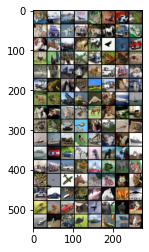

In [53]:
#plot original images:
grid_img = torchvision.utils.make_grid(images.cpu(), nrows=16)
plt.imshow(grid_img.permute(1,2,0))

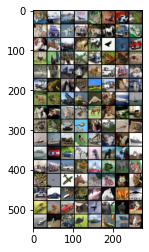

In [54]:
#plot adversarial images:
adv_img = torchvision.utils.make_grid(adversarial_examples.cpu(), nrows=16)
plt.imshow(grid_img.permute(1,2,0))

### (d) (25 points) Implement targeted C&W with L2 norm, lambda=1, confidence=0, max steps=50, using CIFAR10 class 0 test samples. The target class is class 1. Report the testing accuracy on the original class 0 samples, and the proportion of adversarial examples classified as class 1.

In [55]:
with torch.no_grad():
    net.eval()
    # for each batch of images
    running_accuracy = 0
    running_loss = 0
    for images, labels in sub_loader:

        # move images and model to device
        images, labels = images.to(device), labels.to(device)

        # forward
        outputs = net(images)

        # loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # accuracy
        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        running_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

average_loss = running_loss/len(sub_loader)
total_accuracy = running_accuracy/len(sub_loader)
print("Test Loss: {:.3f}".format(average_loss))
print("Test Accuracy: {:.3f}".format(total_accuracy*100)) 

Test Loss: 0.184
Test Accuracy: 94.516


In [56]:
import math
def clean_accuracy(model: nn.Module,
                   x: torch.Tensor,
                   y: torch.Tensor,
                   batch_size: int = 100,
                   device: torch.device = None):
    if device is None:
        device = x.device
    acc = 0.
    n_batches = math.ceil(x.shape[0] / batch_size)
    with torch.no_grad():
        for counter in range(n_batches):
            x_curr = x[counter * batch_size:(counter + 1) *
                       batch_size].to(device)
            y_curr = y[counter * batch_size:(counter + 1) *
                       batch_size].to(device)

            output = model(x_curr)
            acc += (output.max(1)[1] == y_curr).float().sum()

    return acc.item() / x.shape[0]

In [57]:
!pip install torchattacks
import torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
def cw_test_target(model, test_loader):
    model.eval()
    cw = torchattacks.CW(net, c=1, kappa=0, steps=50, lr=0.01)
    cw.set_mode_targeted_by_function(target_map_function=lambda images, labels:1)
    correct_cnt = 0
    total_cnt = 0
    for _, (x, labels) in enumerate(test_loader):
        x, labels = x.to(device), labels.to(device)
        target_labels = torch.ones(len(x))
        #print(target_labels)
        adv = cw(x, labels)
        out = model(adv)
        _, pred_label = torch.max(out.data, 1)
        #print(pred_label)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label.cpu() == target_labels).float().sum()
    acr = float(correct_cnt.double()/total_cnt)
    print("The proportion of class 0 images classified as class 1 is {}".format(acr))
    return acr

cw_acr = cw_test_target(vgg11, sub_loader)

Attack mode is changed to 'targeted(custom)'.
The proportion of class 0 images classified as class 1 is 0.296


## Problem 2 (50 points)

In this problem you will practice implementing **adversarial training** on CIFAR10

**Data.** You will use CIFAR10 classification dataset (10 classes). Pytorch/torchvision has provide a useful dataloader to automatically download and load the data into batches. Code of the data loader has been provided in the template. Please don't modify the data loading part.

### **Problem Description.** Implement **adversarial training** to train VGG11 on CIFAR10.

### (a) (25 points) Implement adversarial training (generate PGD adversarial examples every iteration and train the model with adversarial examples) with PGD (L-infinity norm, epsilon=0.03, step size=0.01, max steps=7). You can initial the model with pre-trained VGG11. Do adversarial training for at least 10 epochs.

In [60]:
def advtrain(model, train_loader):
    model.train()
    adversary = torchattacks.PGD(model = model, eps=0.03, steps=7, alpha=0.01)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.002)
    criterion = nn.CrossEntropyLoss()
    
    total_loss = 0
    batch_count = 0
    correct = 0
    correct_ori = 0
    total = 0
    for epoch in range(10):
        for x, y in tqdm(train_loader):
            x,y = x.to(device), y.to(device)
            outputs = model(x)
            optimizer.zero_grad()
            adv = adversary(x, y)
            adv_outputs = model(adv)
            loss = criterion(adv_outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = adv_outputs.max(1)
            _, pred_ori = outputs.max(1)
            
            total += y.shape[0]
            correct += torch.sum(predicted == y)
            correct_ori += torch.sum(pred_ori == y)
            batch_count += 1
        epoch_avg_loss = total_loss / batch_count
        acc = correct / total
        acc_ori = correct_ori / total
        print ('Epoch [{}/{}], robust accuracy {:.4f}, accuracy {:.4f}'.format(epoch+1, 10, acc, acc_ori))
        #print(acc)
        #print(acc_ori)
    
    return model

In [23]:
vgg11_adv = advtrain(vgg11, train_cifar_loader)

100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


Epoch [1/10], robust accuracy 0.4521, accuracy 0.7040


100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


Epoch [2/10], robust accuracy 0.4612, accuracy 0.7163


100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


Epoch [3/10], robust accuracy 0.4696, accuracy 0.7272


100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


Epoch [4/10], robust accuracy 0.4772, accuracy 0.7376


100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


Epoch [5/10], robust accuracy 0.4851, accuracy 0.7469


100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch [6/10], robust accuracy 0.4927, accuracy 0.7557


100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


Epoch [7/10], robust accuracy 0.5002, accuracy 0.7647


100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch [8/10], robust accuracy 0.5078, accuracy 0.7729


100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch [9/10], robust accuracy 0.5151, accuracy 0.7809


100%|██████████| 391/391 [02:02<00:00,  3.20it/s]

Epoch [10/10], robust accuracy 0.5223, accuracy 0.7881


### (b) (20 points) Implement PGD with L-infinity norm, epsilon=0.03, step size=0.01, max steps=20, to attack the **adversarially trained** VGG11 and generate adversarial examples with the CIFAR10 test set. Report the testing accuracy and robust testing accuracy of the **adversarially trained** VGG11 on CIFAR10 test set.

In [61]:
net1 = vgg11_adv.to(device)
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    net1.eval()
    # for each batch of images
    running_accuracy = 0
    running_loss = 0
    for images, labels in test_cifar_loader:

        # move images and model to device
        images, labels = images.to(device), labels.to(device)

        # forward
        outputs = net1(images)

        # loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # accuracy
        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        running_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

average_loss = running_loss/len(test_cifar_loader)
total_accuracy = running_accuracy/len(test_cifar_loader)
print("Test Loss: {:.3f}".format(average_loss))
print("Test Accuracy: {:.3f}".format(total_accuracy*100))      


Test Loss: 0.890
Test Accuracy: 69.689


In [62]:
adversary = PGDAttack(net1, epsilon=0.03, steps=20, step_size=0.01)
robust_acc = attack_over_test_data(net1, adversary, test_cifar_loader)

100%|██████████| 79/79 [00:56<00:00,  1.39it/s, adv_acc=3665/10000  36.65%]

Got 3665/10000 correct (36.65%) on the perturbed data


### (c) (5 points) Please compare the performance of the pre-trained VGG11 and the adversarially trained VGG11 against PGD attack.

Answer: Compared with pre-trained VGG11, the adversarially trained VGG11 has a better robust accuracy but sacrifies performance on clean images (testing accuracy).